# Introduction
## Using Google Search Volume and News Sentiment to Predict Natural Gas Prices with LSTMs
by Quinn Murphey, Adrian Ramos, and Gabriel Soliz

In [317]:
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data Fetch Stage

## US EIA NYMEX Dataset
TODO EXPLAIN DATASET

In [318]:
# Read csvs to dataframes
nymex_spot_df = pd.read_csv("data/US_EIA_NYMEX_spot.csv")
nymex_futures_df = pd.read_csv("data/US_EIA_NYMEX_futures.csv")

# Turn Date column into a datetime object rather than string
nymex_spot_df["Date"] = nymex_spot_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))
nymex_futures_df["Date"] = nymex_futures_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))

# Trim to Jan 2013 - Jun 2019
nymex_spot_df = nymex_spot_df[(nymex_spot_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_spot_df["Date"] <= datetime(year=2019, month=6, day=30))]
nymex_futures_df = nymex_futures_df[(nymex_futures_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_futures_df["Date"] <= datetime(year=2019, month=6, day=30))]

# Reset index
nymex_spot_df = nymex_spot_df.set_index("Date")
nymex_futures_df = nymex_futures_df.set_index("Date")

# Rename Columns
nymex_spot_df    = nymex_spot_df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Spot Price'})
nymex_futures_df = nymex_futures_df.rename(columns={'Natural Gas Futures Contract 1 (Dollars per Million Btu)':'Futures 1 Price','Natural Gas Futures Contract 2 (Dollars per Million Btu)':'Futures 2 Price','Natural Gas Futures Contract 3 (Dollars per Million Btu)':'Futures 3 Price','Natural Gas Futures Contract 4 (Dollars per Million Btu)':'Futures 4 Price'})

In [319]:
nymex_spot_df

,Spot Price
Date,
2013-01-02,3.30
2013-01-03,3.19
2013-01-04,3.20
2013-01-07,3.30
2013-01-08,3.21
...,...
2019-06-24,2.31
2019-06-25,2.31
2019-06-26,2.34


In [320]:
nymex_futures_df

,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,
2013-01-02,3.233,3.255,3.294,3.349
2013-01-03,3.198,3.214,3.250,3.306
2013-01-04,3.287,3.303,3.337,3.393
2013-01-07,3.266,3.281,3.318,3.374
2013-01-08,3.218,3.234,3.275,3.330
...,...,...,...,...
2019-06-24,2.303,2.284,2.256,2.291
2019-06-25,2.308,2.286,2.260,2.294
2019-06-26,2.291,2.268,2.244,2.275


## Google Trends Dataset

### PyTrends Scraper

In [321]:
import pytrends
from pytrends.request import TrendReq
import time
pytrend = TrendReq()

def get_daily_trends_as_df(keywords, categories, timeframe, countries, search_type):
    # Get pytrend suggestions and store them in exact_keywords
    keywords_codes = [pytrend.suggestions(keyword=i)[0] for i in keywords] 
    df_CODES= pd.DataFrame(keywords_codes)
    exact_keywords = df_CODES['mid'].to_list()

    # Store keywords alongside their respective categories
    individual_exact_keyword = list(zip(*[iter(exact_keywords)]*1, categories))
    individual_exact_keyword = [list(x) for x in individual_exact_keyword]

    # Split timeframe into 6 month chunks
    timeframe_start, timeframe_end = timeframe.split(" ")
    start_date = date.fromisoformat(timeframe_start)
    end_date = date.fromisoformat(timeframe_end)
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months=6)
    dates.append(end_date + relativedelta(days=1))

    # Compute number of fetches required
    max_fetches = len(countries) * len(keywords) * (len(dates) - 1)
    curr_fetches = 0

    trend_dict = {}
    for country in countries:
        for keyword, category in individual_exact_keyword:
            trend_dict[keyword] = pd.DataFrame()
            for i in range(len(dates)-1):
                pytrend.build_payload(kw_list=[keyword], 
                                    timeframe = dates[i].isoformat() + " " + (dates[i + 1] - relativedelta(days=1)).isoformat(), 
                                    geo = country, 
                                    cat=category,
                                    gprop=search_type)
                curr_fetches += 1
                print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete!", end='\r')
                time.sleep(15) # sleep to prevent google shutting us down
                trend_dict[keyword] = pd.concat([trend_dict[keyword], pytrend.interest_over_time()], axis=0)
            i+=1
    df_trends = pd.concat(trend_dict, axis=1)

    df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
    df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
    df_trends.reset_index(level=0,inplace=True) #reset_index
    df_trends.columns = ['Date'] + keywords
    df_trends["Date"] = df_trends["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    df_trends = df_trends.set_index("Date")

    return df_trends

In [322]:
KEYWORDS            = ["Natural Gas","Oil","Coal","Nuclear Power","Wind Power","Hydroelectric","Solar Power","Gold","Silver","Platinum","Copper","Biofuel","Recession","CPI"]
KEYWORDS_CATEGORIES = [904,          904,  904,   0,               0,          0,               0,           904,   904,     904,       904,     0,        0,          0]
TIMEFRAME='2013-01-02 2019-06-28' # Jan 2013 - June 2019
COUNTRIES=["US"] # ISO country code
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

try:
    google_trends_df = pd.read_csv("data/google_trends_dataset.csv")
    google_trends_df["Date"] = google_trends_df["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    google_trends_df = google_trends_df.set_index("Date")
except:
    google_trends_df = get_daily_trends_as_df(KEYWORDS, KEYWORDS_CATEGORIES, TIMEFRAME, COUNTRIES, SEARCH_TYPE)
    google_trends_df.to_csv("data/google_trends_dataset.csv")

google_trends_df

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-01,8,37,0,18,43,15,40,18,35,33,27,34,53,16
2013-01-02,62,95,0,20,60,28,52,23,50,31,72,47,49,55
2013-01-03,54,81,0,23,52,18,56,23,45,15,42,55,41,45
2013-01-04,68,78,27,19,54,23,51,23,43,100,58,37,51,45
2013-01-05,7,68,0,15,33,11,46,23,34,36,54,15,25,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,25,44,0,41,20,6,67,87,75,43,79,31,35,59
2019-06-27,28,56,0,35,30,23,66,77,74,68,68,22,44,60
2019-06-28,30,55,0,38,20,10,66,79,67,79,73,31,38,50


## Financial Times Scraper

# Data Preprocessing Stage

## NYMEX

### Join dataframes (by date)

In [323]:
nymex_df = pd.concat([nymex_spot_df, nymex_futures_df],axis=1)
nymex_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2013-01-02,3.30,3.233,3.255,3.294,3.349
2013-01-03,3.19,3.198,3.214,3.250,3.306
2013-01-04,3.20,3.287,3.303,3.337,3.393
2013-01-07,3.30,3.266,3.281,3.318,3.374
2013-01-08,3.21,3.218,3.234,3.275,3.330
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


However, there are some NaN values due to the dates covered differing

In [324]:
nymex_df.isna().sum()

Spot Price         19
Futures 1 Price    33
Futures 2 Price    33
Futures 3 Price    33
Futures 4 Price    33
dtype: int64

### Fill spot price voids 
Interpolate all voids linearly (by column)

In [325]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Interpolate Weekends and Holidays

In [326]:
nymex_df = nymex_df.reindex(pd.date_range(nymex_df.index[0],nymex_df.index[-1],freq='d'))
nymex_df


,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
2013-01-02,3.30,3.233,3.255,3.294,3.349
2013-01-03,3.19,3.198,3.214,3.250,3.306
2013-01-04,3.20,3.287,3.303,3.337,3.393
2013-01-05,NaN,NaN,NaN,NaN,NaN
2013-01-06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275
2019-06-27,2.32,2.324,2.298,2.325,2.413


In [327]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Interpolate Weekends

In [ ]:
# TODO

### Normalize columns
First log all values: $x' = \log{x}$, then normalize: $x' = (x - \mu)/\sigma$

Check for negative values

In [328]:
(nymex_df <= 0).sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

Log each value

In [329]:
nymex_df_normalized = np.log(nymex_df)
nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
2013-01-02,1.193922,1.173410,1.180192,1.192103,1.208662
2013-01-03,1.160021,1.162526,1.167516,1.178655,1.195739
2013-01-04,1.163151,1.189975,1.194831,1.205072,1.221714
2013-01-05,1.173514,1.187843,1.192608,1.203172,1.219846
2013-01-06,1.183770,1.185707,1.190381,1.201269,1.217974
...,...,...,...,...,...
2019-06-24,0.837248,0.834213,0.825928,0.813593,0.828988
2019-06-25,0.837248,0.836381,0.826804,0.815365,0.830297
2019-06-26,0.850151,0.828988,0.818898,0.808260,0.821980
2019-06-27,0.841567,0.843290,0.832039,0.843720,0.880871


Normalize each row

In [330]:
for column in nymex_df_normalized.columns:
    nymex_df_normalized[column] = (nymex_df_normalized[column] - nymex_df_normalized[column].mean()) / nymex_df_normalized[column].std()

nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
2013-01-02,0.254080,0.197720,0.183293,0.195539,0.253670
2013-01-03,0.114006,0.148998,0.123394,0.129185,0.186952
2013-01-04,0.126938,0.271867,0.252468,0.259534,0.321058
2013-01-05,0.169755,0.262325,0.241965,0.250160,0.311413
2013-01-06,0.212132,0.252762,0.231438,0.240768,0.301749
...,...,...,...,...,...
2019-06-24,-1.219618,-1.320588,-1.490744,-1.672109,-1.706515
2019-06-25,-1.219618,-1.310881,-1.486608,-1.663368,-1.699759
2019-06-26,-1.166304,-1.343973,-1.523963,-1.698425,-1.742698
2019-06-27,-1.201770,-1.279957,-1.461867,-1.523457,-1.438656


## Google Trends

### Normalize Columns 
$x' = (x- \mu)/\sigma$

In [331]:
google_trends_df_normalized = google_trends_df.copy()

for column in google_trends_df_normalized.columns:
    google_trends_df_normalized[column] = (google_trends_df_normalized[column] - google_trends_df_normalized[column].mean()) / google_trends_df_normalized[column].std()

google_trends_df_normalized

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-01,-1.183636,-0.692835,-0.636261,-1.621756,-0.478050,-1.016930,-1.468401,-1.850949,-1.264325,-0.050772,-1.067542,-0.327359,0.381374,-1.564727
2013-01-02,1.505144,2.434172,-0.636261,-1.516948,0.416303,-0.498769,-0.733478,-1.592328,-0.354293,-0.160906,1.467259,0.301774,0.168334,0.270359
2013-01-03,1.106806,1.679377,-0.636261,-1.359737,-0.004569,-0.897354,-0.488503,-1.592328,-0.657637,-1.041976,-0.222609,0.688932,-0.257745,-0.200176
2013-01-04,1.803897,1.517635,0.560576,-1.569352,0.100649,-0.698062,-0.794721,-1.592328,-0.778975,3.638710,0.678654,-0.182174,0.274854,-0.200176
2013-01-05,-1.233428,0.978496,-0.636261,-1.778967,-1.004140,-1.176364,-1.100940,-1.592328,-1.324994,0.114429,0.453339,-1.246860,-1.109902,-1.282406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,-0.337168,-0.315437,-0.636261,-0.416469,-1.688057,-1.375656,0.185177,1.718018,1.162426,0.499897,1.861562,-0.472543,-0.577304,0.458573
2019-06-27,-0.187791,0.331530,-0.636261,-0.730891,-1.161967,-0.698062,0.123933,1.200777,1.101757,1.876569,1.241944,-0.908097,-0.097965,0.505627
2019-06-28,-0.088207,0.277616,-0.636261,-0.573680,-1.688057,-1.216222,0.123933,1.304225,0.677076,2.482305,1.523588,-0.472543,-0.417524,0.035092


# Data Visualization

We will create a `plot` function that will be able to plot our data with, or without label and with or without predictions

In [388]:
def plot(data, units=None, input_width=0, label_width=0, predictions=None, density=1, seperate=True, file=None):
    """
    data: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted
    units: if seperate is True, a list of strings, else a string
    input_width: input width of time series window
    label_width: label width of time series window
    predictions: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted (should match up with data column names)
    density: average every 'density' number of entries to end up plotting 1/density as many entries
    file: file to save figure to (None if no save)
    """
    # Verify units
    if units==None:
        units = [""] * len(data.columns)
    elif isinstance(units, str):
        units = [units] * len(data.columns)
    elif seperate and len(units) != len(data.columns):
        print("ERROR: Make sure units is the same length as data")
        return

    # Create new data if density != 1 using the mean of rolling windows
    if density != 1:
        first_row = data.iloc[0, :]
        last_row = data.iloc[-1, :] 
        data = data.rolling(density).mean().iloc[::density,:]
        data.iloc[0] = first_row
        data.iloc[-1] = last_row

    # Create a 12x12 figure
    fig = plt.figure(figsize=(20,10))

    # If plotting seperate Divide the fig into N subplots where N is the number of columns in data
    if seperate:
        ncols=math.ceil(math.sqrt(len(data.columns)))
        nrows=math.ceil( len(data.columns) / ncols)
        i = 1
    else: 
        plt.ylabel(units[0])
        plt.xlabel("Date")

    # Iterate over all columns in data
    for column, unit in zip(data.columns, units):
        # Label seperate subfigs
        if seperate:
            ax = plt.subplot(nrows,ncols,i)
            ax.set_title(column)
            plt.ylabel(unit)
            plt.xlabel('Date')
            i+=1

        # Plot data
        plt.plot(data.index,data[column])

        # Plot labels
        # TODO

        # Plot predictions
        # TODO

    if not seperate:
        plt.legend(labels=data.columns)
    plt.tight_layout()
    if file:
        plt.savefig(file)
    else:
        plt.show()

### NYMEX Dataset

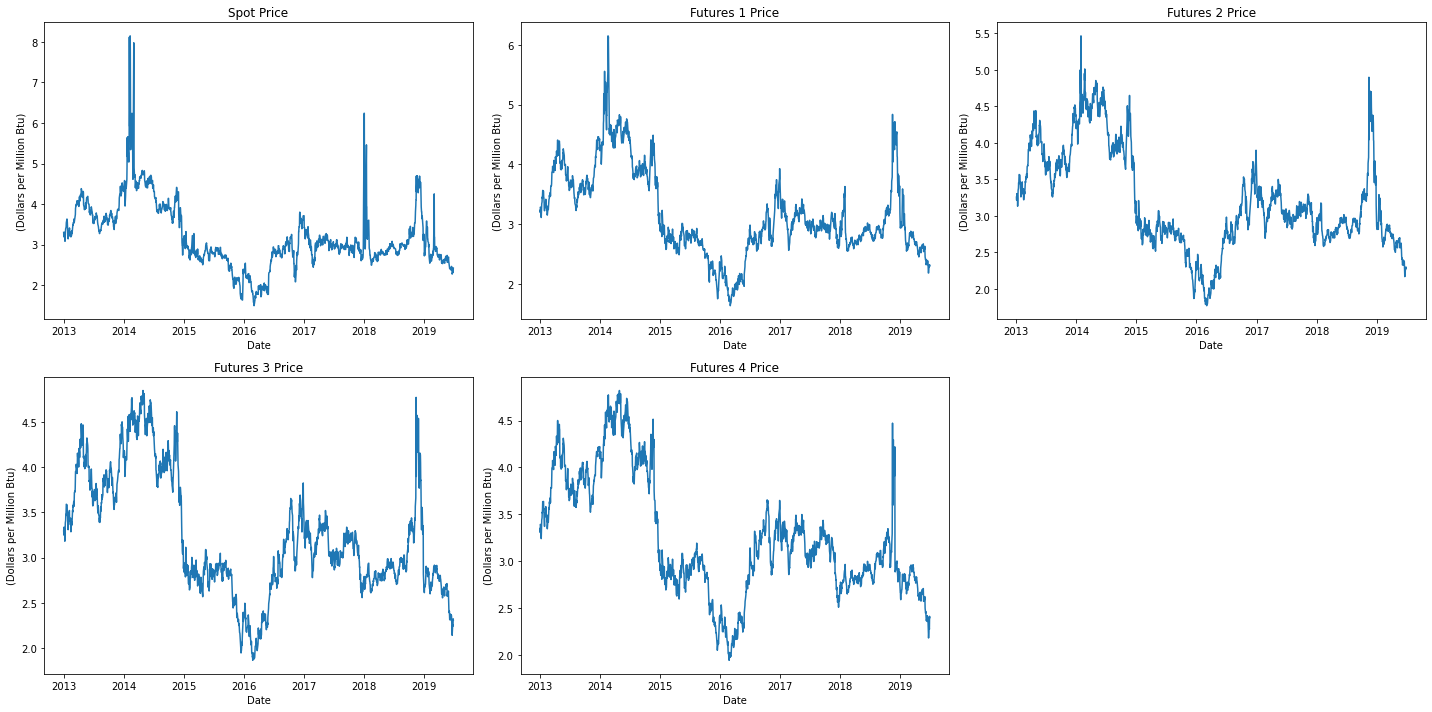

In [389]:
plot(nymex_df,units="(Dollars per Million Btu)", seperate=True, density=1, file="images/nymex_data.png")

### Google Trends Dataset

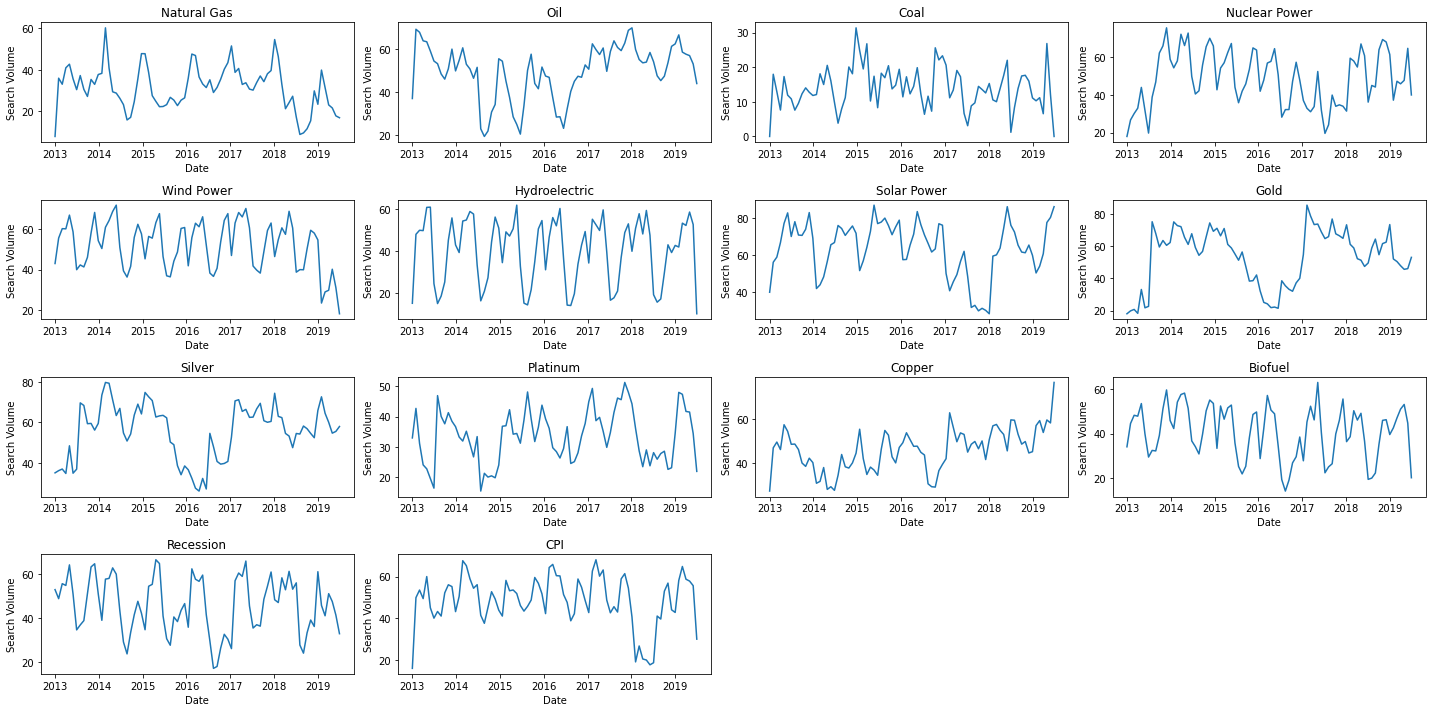

In [390]:
plot(google_trends_df,units="Search Volume", seperate=True, density=30, file="images/google_trends_data.png")

# Model Training Stage

# Model Testing Stage